In [3]:
import pandas as pd
import numpy as np
from data_master import DataMaster
from utils import func
from scipy.stats import norm
import matplotlib.pyplot as plt
from tqdm import tqdm
master = DataMaster()
from utils.func import center
from quantstats.stats import sharpe
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from pandas.tseries.offsets import BDay
import time
import random
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas

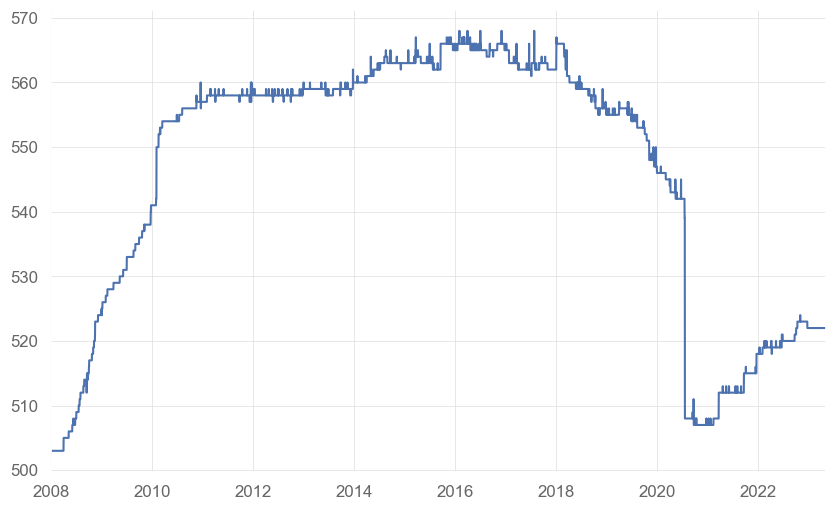

In [4]:
universe = master.baskets.get_index_historical_components('GSPC')
P = func.presence_matrix(universe).loc['2008':]
P.sum(1).plot()
market_data = pd.read_parquet('data/US/mkt_data.pq')
balance_sheet = pd.read_parquet('data/US/balance_sheets.pq')
GICS = pd.read_parquet('data/US/GICS.pq')
P = pd.read_parquet('data/US/universe_table.pq')
R = market_data['close'].unstack().reindex_like(P).pct_change()
income_statement = pd.read_parquet('data/US/income_statement.pq')
earnings = pd.read_parquet('data/US/earnings.pq')
cash_flow = pd.read_parquet('data/US/cash_flow.pq')

In [5]:
earnings = pd.read_parquet('data/US/earnings.pq')
earnings['Date'] = pd.to_datetime(earnings['reportDate'])
earnings = earnings.droplevel(0).set_index('Date',append=True)
earnings = earnings.reorder_levels(['Date','Ticker'])
earnings = earnings[~earnings.index.duplicated(keep='first')]
earnings = earnings[earnings['epsActual'].notna()]
earnings

,,reportDate,date,beforeAfterMarket,currency,epsActual,epsEstimate,epsDifference,surprisePercent
Date,Ticker,,,,,,,,
2000-02-17,A,2000-02-17,2000-01-31,None,USD,0.30,0.22,0.08,36.3636
2000-05-16,A,2000-05-16,2000-04-30,None,USD,0.35,0.32,0.03,9.3750
2000-08-17,A,2000-08-17,2000-07-31,None,USD,0.39,0.20,0.19,95.0000
2000-11-20,A,2000-11-20,2000-10-31,None,USD,0.73,0.54,0.19,35.1852
2001-02-20,A,2001-02-20,2001-01-31,None,USD,0.51,0.45,0.06,13.3333
...,...,...,...,...,...,...,...,...,...
2022-02-15,ZTS,2022-02-15,2021-12-31,BeforeMarket,USD,1.00,0.96,0.04,4.1667
2022-05-05,ZTS,2022-05-05,2022-03-31,BeforeMarket,USD,1.32,1.23,0.09,7.3171
2022-08-04,ZTS,2022-08-04,2022-06-30,BeforeMarket,USD,1.20,1.22,-0.02,-1.6393


In [6]:
balance_sheet = pd.read_parquet('data/US/balance_sheets.pq')
balance_sheet['Date'] = pd.to_datetime(balance_sheet['filing_date'])
balance_sheet = balance_sheet.droplevel(0).set_index('Date',append=True)
balance_sheet = balance_sheet.reorder_levels(['Date','Ticker'])
balance_sheet = balance_sheet[~balance_sheet.index.duplicated(keep='first')]
balance_sheet

,,date,filing_date,currency_symbol,totalAssets,intangibleAssets,earningAssets,otherCurrentAssets,totalLiab,totalStockholderEquity,deferredLongTermLiab,...,preferredStockRedeemable,capitalSurpluse,liabilitiesAndStockholdersEquity,cashAndShortTermInvestments,propertyPlantAndEquipmentGross,propertyPlantAndEquipmentNet,accumulatedDepreciation,netWorkingCapital,netInvestedCapital,commonStockSharesOutstanding
Date,Ticker,,,,,,,,,,,,,,,,,,,,,
1999-01-31,A,1999-01-31,1999-01-31,USD,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,462500000.00
1999-04-30,A,1999-04-30,1999-04-30,USD,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,461764706.00
1999-07-31,A,1999-07-31,1999-07-31,USD,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,450000000.00
1999-10-31,A,1999-10-31,1999-10-31,USD,5444000000.00,None,None,404000000.00,2062000000.00,3382000000.00,None,...,None,None,5444000000.00,None,1387000000.00,1387000000.00,None,None,None,440000000.00
2000-03-15,A,2000-01-31,2000-03-15,USD,7107000000.00,None,None,560000000.00,2621000000.00,4486000000.00,None,...,None,None,7107000000.00,1410000000.00,1408000000.00,1408000000.00,None,None,None,440000000.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-15,ZTS,2021-12-31,2022-02-15,USD,13900000000.00,1474000000.00,None,392000000.00,9356000000.00,4543000000.00,320000000.00,...,None,1068000000.00,13899000000.00,3482000000.00,None,2603000000.00,None,5133000000.00,11135000000.00,475600000.00
2022-05-05,ZTS,2022-03-31,2022-05-05,USD,13860000000.00,1430000000.00,None,423000000.00,9202000000.00,4658000000.00,287000000.00,...,None,1046000000.00,13860000000.00,3135000000.00,None,2676000000.00,None,3803000000.00,11236000000.00,474100000.00
2022-08-04,ZTS,2022-06-30,2022-08-04,USD,13770000000.00,1390000000.00,None,507000000.00,9190000000.00,4580000000.00,274000000.00,...,None,1059000000.00,13770000000.00,2648000000.00,None,2752000000.00,None,3600000000.00,11153000000.00,471500000.00


In [7]:
cash_flow = pd.read_parquet('data/US/cash_flow.pq')
cash_flow['Date'] = pd.to_datetime(cash_flow['filing_date'])
cash_flow = cash_flow.droplevel(0).set_index('Date',append=True)
cash_flow = cash_flow.reorder_levels(['Date','Ticker'])
cash_flow = cash_flow[~cash_flow.index.duplicated(keep='first')]

EPS SURPRISE

In [8]:
eps_actual = earnings['epsActual'].unstack().reindex_like(P).ffill().astype(float)
eps_estimate = earnings['epsEstimate'].unstack().reindex_like(P).ffill().astype(float)
alpha  = (eps_actual - eps_estimate).reindex_like(P).ffill()[P]

Sharpe      1.862
Turnover    0.069
biais       1.782
dtype: float64

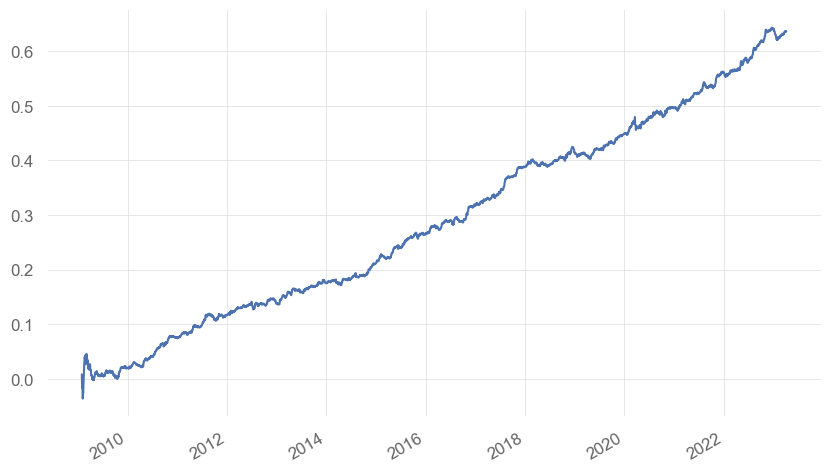

In [9]:
signal = alpha[P]
signal = signal[P].rolling(252).rank(axis=0,pct=True,ascending=True).clip(0.01,0.99).apply(norm.ppf)
signal = signal[P].rank(axis=1,pct=True,ascending=True).clip(0.01,0.99).apply(norm.ppf)

signal[signal.abs()<0.5] = None

signal = signal[P].groupby(GICS['gicind'],axis=1).apply(center)
signal = signal[P].div(signal[P].abs().sum(1),0)


PNL = (signal[P].shift()*R).sum(1).replace({0:np.nan}).dropna()
sr = sharpe(PNL)
turnover = signal.fillna(0).diff().abs().sum(1).mean()
PNL.cumsum().plot()
pd.Series({'Sharpe':sr,'Turnover':turnover,'biais':PNL.mean()*1e4}).round(3)

EM 

In [10]:
mkt_cap = market_data['MktCap'].unstack().reindex_like(P).astype(float)
ltdebt = balance_sheet['longTermDebt'].unstack().reindex_like(P).ffill().astype(float)
stdebt = balance_sheet['shortTermDebt'].unstack().reindex_like(P).ffill().astype(float)
cash_equiv = balance_sheet['cashAndEquivalents'].unstack().reindex_like(P).ffill().astype(float)
EV = mkt_cap + (ltdebt+stdebt)  - cash_equiv.fillna(0)
ebitda = income_statement['ebitda'].unstack().reindex_like(P).ffill().astype(float)
EM = EV / ebitda
EM = EM.reindex_like(P).ffill()

Sharpe      1.6
Turnover    0.5
biais       2.3
dtype: float64

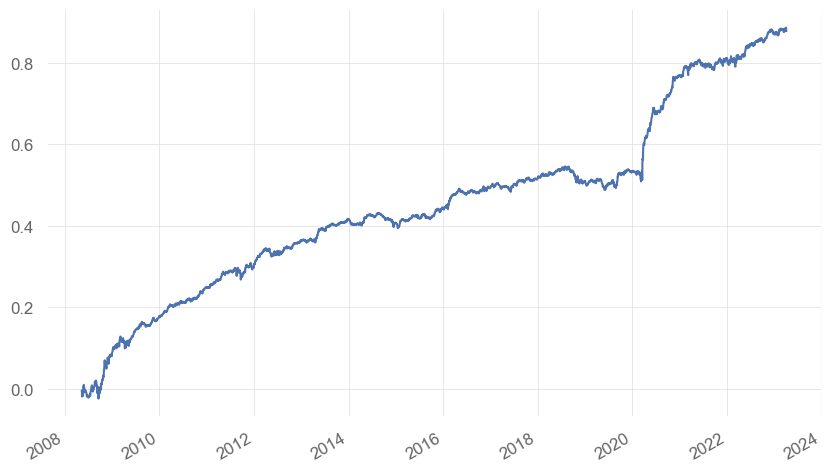

In [11]:
signal = EM.copy()
signal = signal[P].rolling(50).rank(axis=0,pct=True,ascending=False).clip(0.01,0.99).apply(norm.ppf)
signal = signal[P].rank(axis=1,pct=True,ascending=True).clip(0.01,0.99).apply(norm.ppf)

signal[signal.abs()<0.5] = None
signal.count(1)

signal = signal[P].groupby(GICS['gicsect'],axis=1).apply(center)
signal = signal[P].div(signal[P].abs().sum(1),0)

PNL = (signal[P].shift()*R).sum(1).replace({0:np.nan}).dropna()
sr = sharpe(PNL)
turnover = signal.fillna(0).diff().abs().sum(1).mean()
PNL.cumsum().plot()
pd.Series({'Sharpe':sr,'Turnover':turnover,'biais':PNL.mean()*1e4}).round(1)

PB Ratio

In [12]:
totalAssets = balance_sheet['totalAssets'].unstack().reindex_like(P).ffill().astype(float)
totalLiabilities = balance_sheet['totalLiab'].unstack().reindex_like(P).ffill().astype(float)
book_value = totalAssets - totalLiabilities
shares = balance_sheet['commonStockSharesOutstanding'].unstack().reindex_like(P).ffill().astype(float)
book_value_share = book_value/ shares
close = market_data['close'].unstack().reindex_like(P).astype(float).ffill()
pb_ratio = (close/book_value_share)

Sharpe      1.3
Turnover    0.8
biais       2.2
dtype: float64

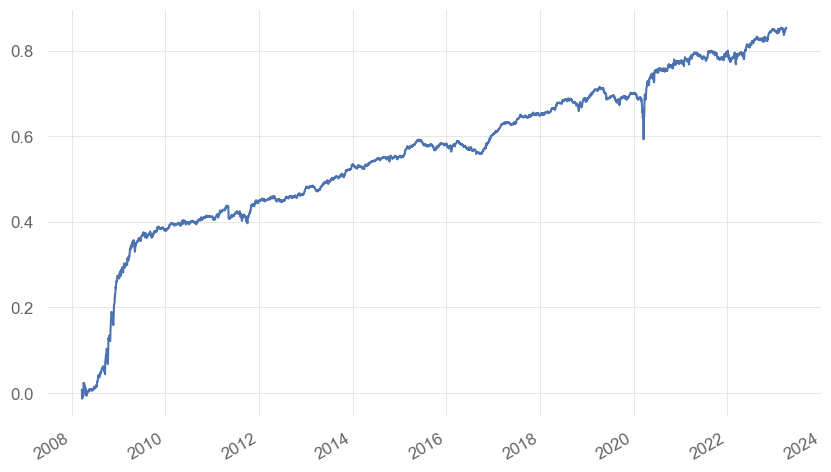

In [13]:
signal = pb_ratio[P].rank(axis=1,pct=True,ascending=True).clip(0.01,0.99).apply(norm.ppf)
signal = signal[P].rolling(20).rank(axis=0,pct=True,ascending=False).clip(0.01,0.99).apply(norm.ppf)
signal = signal[P].rank(axis=1,pct=True,ascending=True).clip(0.01,0.99).apply(norm.ppf)

signal[signal.abs()<0.5] = None
signal.count(1)

signal = signal[P].groupby(GICS['gicind'],axis=1).apply(center)
signal = signal[P].div(signal[P].abs().sum(1),0)

PNL = (signal[P].shift()*R).sum(1).replace({0:np.nan}).dropna()
sr = sharpe(PNL)
turnover = signal.fillna(0).diff().abs().sum(1).mean()
PNL.cumsum().plot()
pd.Series({'Sharpe':sr,'Turnover':turnover,'biais':PNL.mean()*1e4}).round(1)

# Squeeze

In [51]:
import pandas_ta as ta
from tqdm import tqdm
results ={}
for ticker in tqdm(market_data.index.get_level_values(1).unique()[:5]):
    df_ticker = market_data.xs(ticker,level=1)
    try :
        metrics = ta.psar(df_ticker['high'],
                                df_ticker['low'],
                                df_ticker['close'],
                                length = 25
                                ).fillna(0)
        metrics = metrics.iloc[:,0] - metrics.iloc[:,1]
        results[ticker] = metrics

    except :
        print(ticker)



100%|██████████| 5/5 [00:03<00:00,  1.60it/s]


Sharpe      0.3
Turnover    0.2
biais       3.7
dtype: float64

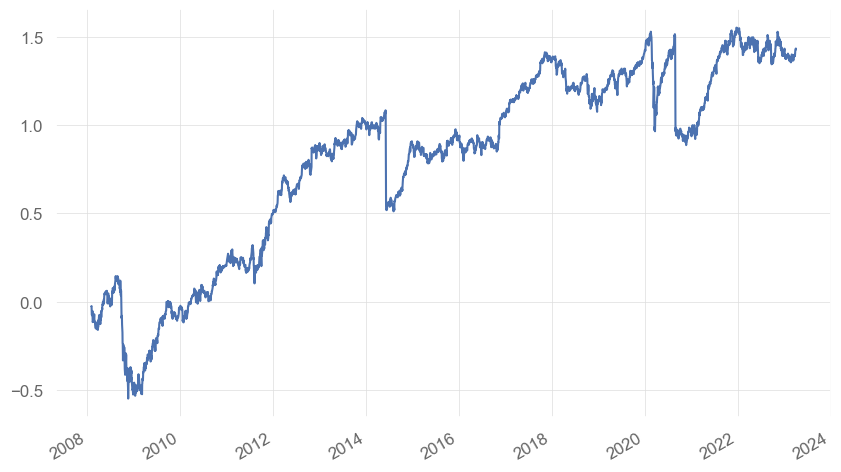

In [53]:
metrics = pd.concat(results,axis=1).reindex_like(P).ffill()
signal = metrics[P].rank(axis=1,pct=True,ascending=True).clip(0.01,0.99).apply(norm.ppf)
pd.concat(results,axis=1).stack()

# signal = signal[P].rolling(20).rank(axis=0,pct=True,ascending=False).clip(0.01,0.99).apply(norm.ppf)
# signal = signal[P].rank(axis=1,pct=True,ascending=True).clip(0.01,0.99).apply(norm.ppf)

# signal[signal.abs()<0.5] = None
# signal.count(1)

# signal = signal[P].groupby(GICS['gicind'],axis=1).apply(center)
signal = signal[P].div(signal[P].abs().sum(1),0)

PNL = (signal[P].shift()*R).sum(1).replace({0:np.nan}).dropna()
sr = sharpe(PNL)
turnover = signal.fillna(0).diff().abs().sum(1).mean()
PNL.cumsum().plot()
pd.Series({'Sharpe':sr,'Turnover':turnover,'biais':PNL.mean()*1e4}).round(1)